# Homework 3 (Python)
Converted from the original RMarkdown to a Python notebook using torch for modeling.


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from pathlib import Path

# Reproducibility
torch.manual_seed(0)
rng = np.random.default_rng(0)

data_dir = Path('.')
train_df = pd.read_csv(data_dir / 'mnist_train.csv')
test_df = pd.read_csv(data_dir / 'mnist_test.csv')
val_df = pd.read_csv(data_dir / 'mnist_val.csv')

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}, Val shape: {val_df.shape}")


Train shape: (11200, 785), Test shape: (2400, 785), Val shape: (2400, 785)


In [2]:
def filter_digits(df, digit_a, digit_b):
    filtered = df[df['label'].isin([digit_a, digit_b])].copy()
    x = filtered.drop(columns=['label']).to_numpy(dtype=np.float32)
    y = (filtered['label'] == digit_b).astype(np.float32).to_numpy()
    x_tensor = torch.tensor(x)
    y_tensor = torch.tensor(y).unsqueeze(1)
    return x_tensor, y_tensor


class TwoLayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.act = nn.ReLU()
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.out(self.fc2(x))
        return x


def run_experiment(digit_a, digit_b, epochs=30, batch_sizes=(64, 128, 256), hidden_sizes=(64, 128, 256), base_lr=0.1, decay_rate=0.7):
    train_x, train_y = filter_digits(train_df, digit_a, digit_b)
    val_x, val_y = filter_digits(val_df, digit_a, digit_b)
    test_x, test_y = filter_digits(test_df, digit_a, digit_b)

    input_dim = train_x.shape[1]
    loss_fn = nn.BCELoss()
    history = {}
    best_val = float('inf')
    best_state = None
    best_config = None

    for batch_size in batch_sizes:
        for hidden_dim in hidden_sizes:
            model = TwoLayerMLP(input_dim, hidden_dim)
            optimizer = torch.optim.SGD(model.parameters(), lr=base_lr)

            train_loss_history = []
            val_loss_history = []

            for epoch in range(epochs):
                lr = base_lr * (decay_rate ** epoch)
                for group in optimizer.param_groups:
                    group['lr'] = lr

                perm = torch.randperm(train_x.shape[0])
                for start in range(0, train_x.shape[0], batch_size):
                    idx = perm[start:start + batch_size]
                    x_batch = train_x[idx]
                    y_batch = train_y[idx]

                    optimizer.zero_grad()
                    preds = model(x_batch)
                    loss = loss_fn(preds, y_batch)
                    loss.backward()
                    optimizer.step()

                with torch.no_grad():
                    train_pred = model(train_x)
                    val_pred = model(val_x)
                    train_loss = loss_fn(train_pred, train_y).item()
                    val_loss = loss_fn(val_pred, val_y).item()

                train_loss_history.append(train_loss)
                val_loss_history.append(val_loss)

            key = f"Batch_{batch_size}_Hidden_{hidden_dim}"
            history[key] = {"train": train_loss_history, "val": val_loss_history}

            if min(val_loss_history) < best_val:
                best_val = min(val_loss_history)
                best_state = {k: v.clone() for k, v in model.state_dict().items()}
                best_config = key

    # Evaluate best model on test set
    best_hidden = int(best_config.split('_')[-1])
    best_model = TwoLayerMLP(input_dim, best_hidden)
    best_model.load_state_dict(best_state)
    best_model.eval()
    with torch.no_grad():
        test_probs = best_model(test_x).squeeze().numpy()
        test_labels = test_y.squeeze().numpy()
        auc = roc_auc_score(test_labels, test_probs)
        fpr, tpr, _ = roc_curve(test_labels, test_probs)

    return history, best_config, auc, (fpr, tpr)


def plot_losses(history, title):
    plt.figure(figsize=(10, 5))
    for key, series in history.items():
        plt.plot(range(1, len(series['train']) + 1), series['train'], label=f"{key} train")
        plt.plot(range(1, len(series['val']) + 1), series['val'], linestyle='--', label=f"{key} val")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_roc(roc_data, label):
    fpr, tpr = roc_data
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()


Best config 3 vs 5: Batch_64_Hidden_128, Test AUC: 0.9981
Best config 4 vs 9: Batch_64_Hidden_256, Test AUC: 0.9899


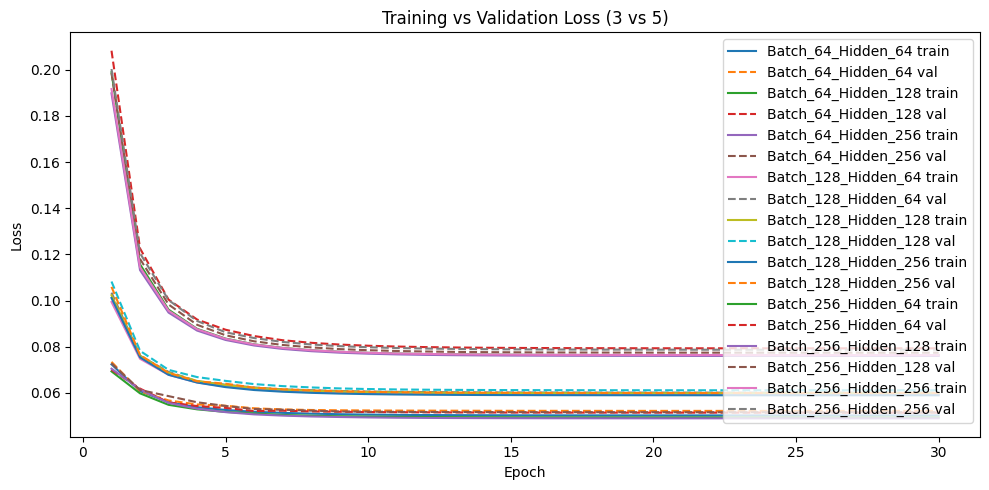

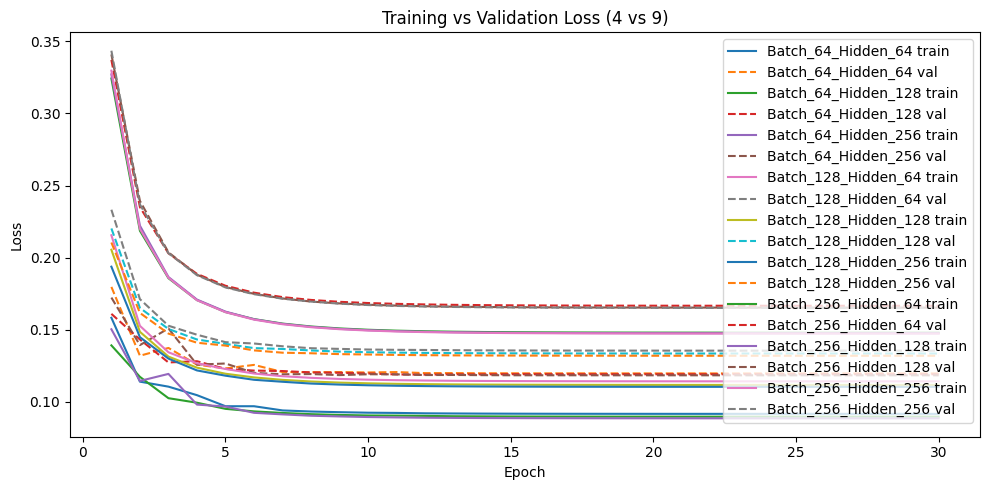

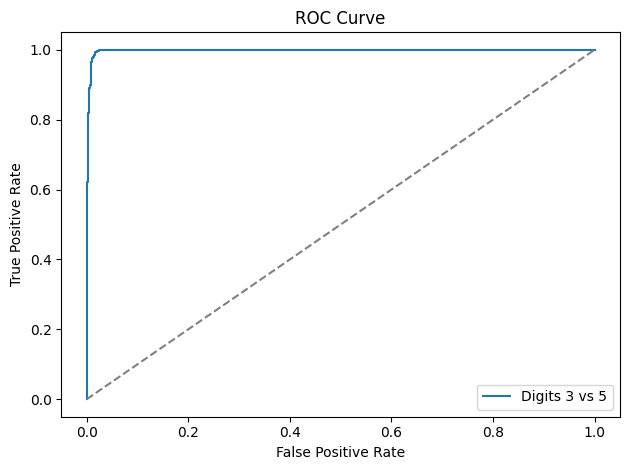

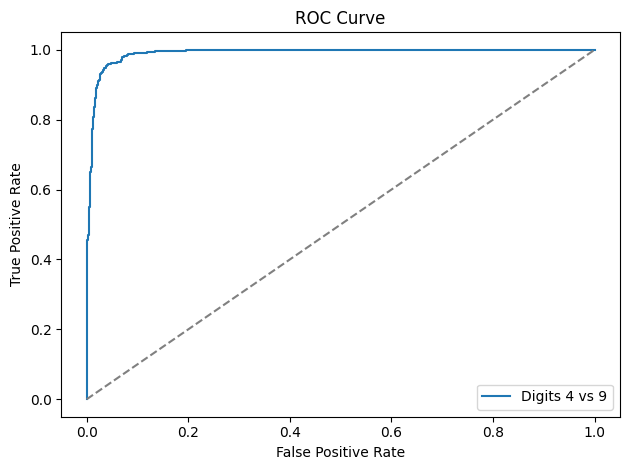

In [3]:
# Run experiments for digit pairs
history_35, best_35, auc_35, roc_35 = run_experiment(3, 5)
history_49, best_49, auc_49, roc_49 = run_experiment(4, 9)

print(f"Best config 3 vs 5: {best_35}, Test AUC: {auc_35:.4f}")
print(f"Best config 4 vs 9: {best_49}, Test AUC: {auc_49:.4f}")

plot_losses(history_35, 'Training vs Validation Loss (3 vs 5)')
plot_losses(history_49, 'Training vs Validation Loss (4 vs 9)')
plot_roc(roc_35, 'Digits 3 vs 5')
plot_roc(roc_49, 'Digits 4 vs 9')


Logistic regression AUC (3 vs 5): 0.9951
Logistic regression AUC (4 vs 9): 0.9556


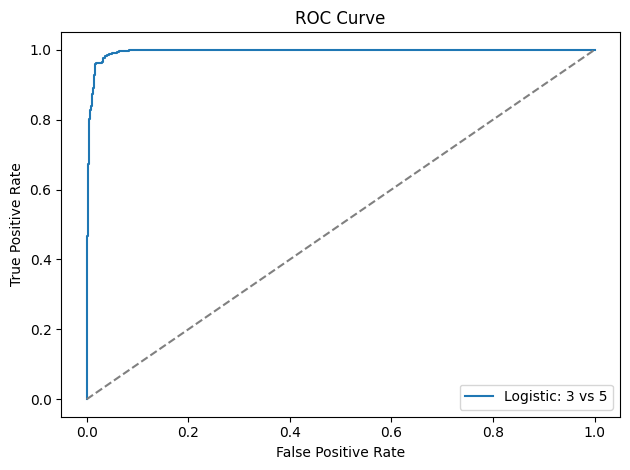

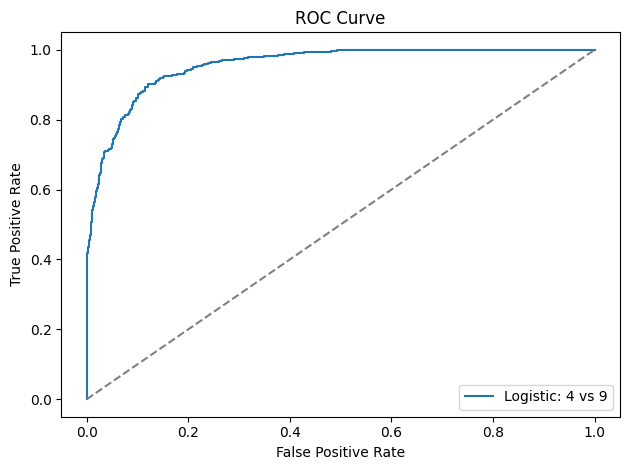

In [4]:
class LogisticClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
        self.out = nn.Sigmoid()

    def forward(self, x):
        return self.out(self.fc(x))


def train_and_eval_logistic(digit_a, digit_b, epochs=30, base_lr=0.1, decay_rate=0.7):
    train_x, train_y = filter_digits(train_df, digit_a, digit_b)
    test_x, test_y = filter_digits(test_df, digit_a, digit_b)

    input_dim = train_x.shape[1]
    model = LogisticClassifier(input_dim)
    optimizer = torch.optim.SGD(model.parameters(), lr=base_lr)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        lr = base_lr * (decay_rate ** epoch)
        for group in optimizer.param_groups:
            group['lr'] = lr
        optimizer.zero_grad()
        preds = model(train_x)
        loss = loss_fn(preds, train_y)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        test_probs = model(test_x).squeeze().numpy()
        test_labels = test_y.squeeze().numpy()
        auc = roc_auc_score(test_labels, test_probs)
        fpr, tpr, _ = roc_curve(test_labels, test_probs)
    return auc, (fpr, tpr)


a_35, roc_log_35 = train_and_eval_logistic(3, 5)
a_49, roc_log_49 = train_and_eval_logistic(4, 9)

print(f"Logistic regression AUC (3 vs 5): {a_35:.4f}")
print(f"Logistic regression AUC (4 vs 9): {a_49:.4f}")

plot_roc(roc_log_35, 'Logistic: 3 vs 5')
plot_roc(roc_log_49, 'Logistic: 4 vs 9')
